In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
df = pd.read_csv('times.csv')

In [3]:
df = df.iloc[:, 1:]
df

,solved,time,date,puzzle_id
0,True,448,2024/01/01,21644
1,True,97,2024/01/02,21650
2,True,167,2024/01/03,21653
3,True,121,2024/01/04,21663
4,True,103,2024/01/05,21664
...,...,...,...,...
361,True,117,2024/12/27,22516
362,True,203,2024/12/28,22519
363,True,256,2024/12/29,22517
364,True,120,2024/12/30,22529


In [4]:
df = df[df['solved'] == True]

In [5]:
times_df = df[['time', 'date']]

<Axes: xlabel='date'>

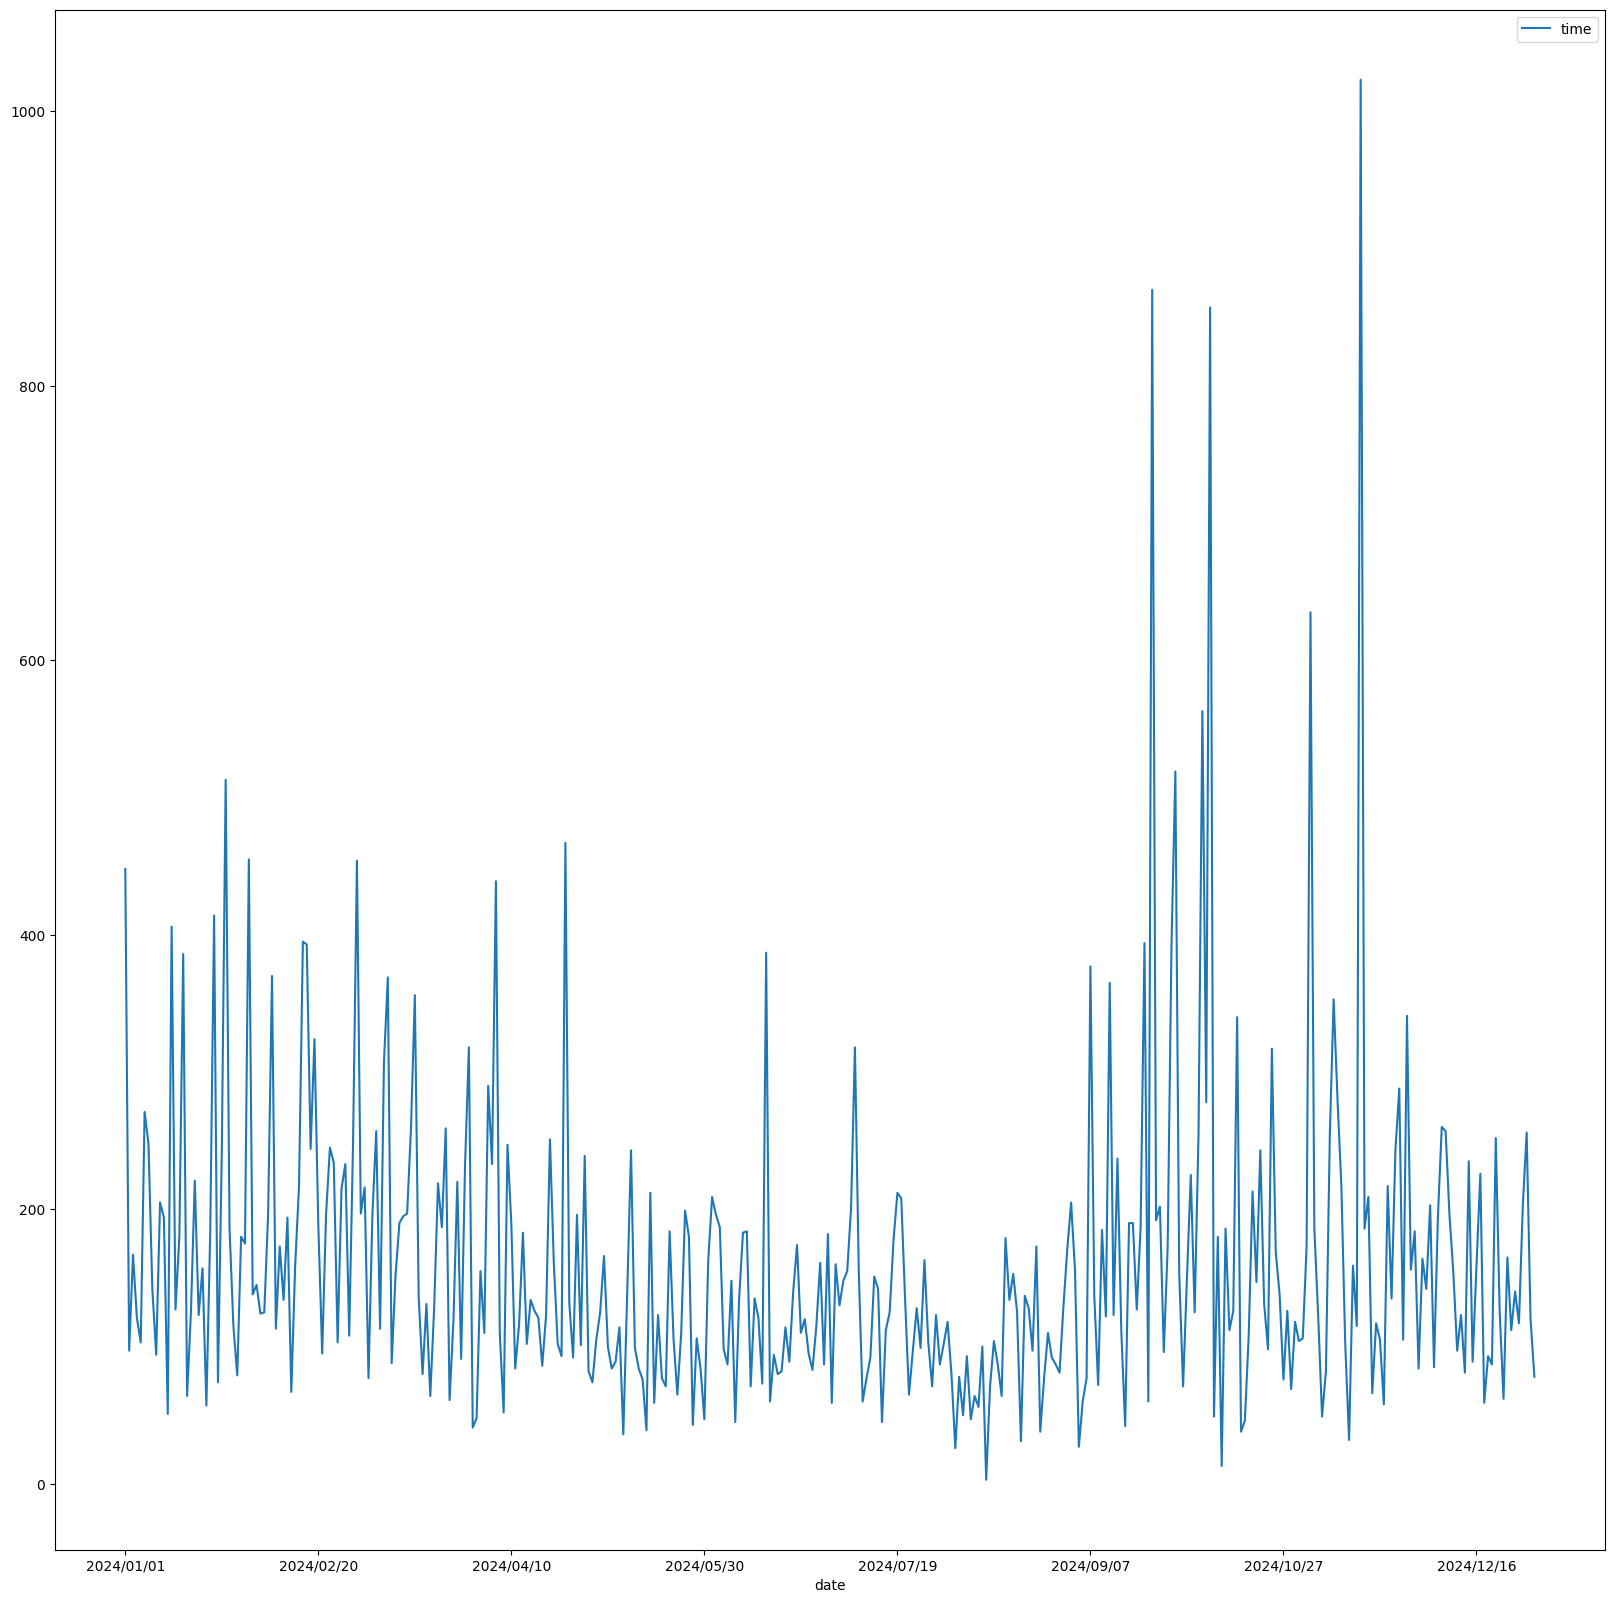

In [6]:
times_df.plot(kind = 'line', x='date' , y = 'time', figsize= (20,20))

### This looks alot better than 2023 but man i fell off near the end


In [7]:



# high end matters more honselt  
lo_q, hi_q = 0.01, 0.91

t = times_df.copy()
t["date"] = pd.to_datetime(t["date"], format="%Y/%m/%d", errors="coerce")
t["time"] = pd.to_numeric(t["time"], errors="coerce")
t = t.dropna(subset=["date", "time"])
t["month"] = t["date"].dt.to_period("M").astype(str)

# normalize per-month by clipping to each months percentile bounds via winsorization
bounds = t.groupby("month")["time"].quantile([lo_q, hi_q]).unstack()
bounds.columns = ["lo", "hi"]
t = t.join(bounds, on="month")
t["time_norm"] = t["time"].clip(lower=t["lo"], upper=t["hi"])

# monthly table
monthly_table = (
    t.groupby("month")
     .agg(
         n=("time", "size"),
         avg_seconds=("time", "mean"),
         avg_seconds_norm=("time_norm", "mean"),
     )
     .reset_index()
     .sort_values("month")
)

# yearly averages 
print(f"Yearly average (raw):        {t['time'].mean():.2f} sec")
print(f"Yearly average (normalized): {t['time_norm'].mean():.2f} sec")

monthly_table


Yearly average (raw):        163.14 sec
Yearly average (normalized): 153.08 sec


,month,n,avg_seconds,avg_seconds_norm
0,2024-01,31,192.709677,187.935484
1,2024-02,29,207.172414,203.998621
2,2024-03,31,190.612903,184.651613
3,2024-04,30,162.133333,148.926333
4,2024-05,31,109.709677,106.883871
5,2024-06,30,128.766667,121.562667
6,2024-07,31,131.645161,127.629032
7,2024-08,31,90.709677,88.364516
8,2024-09,30,207.066667,187.117333
9,2024-10,31,182.935484,157.748387


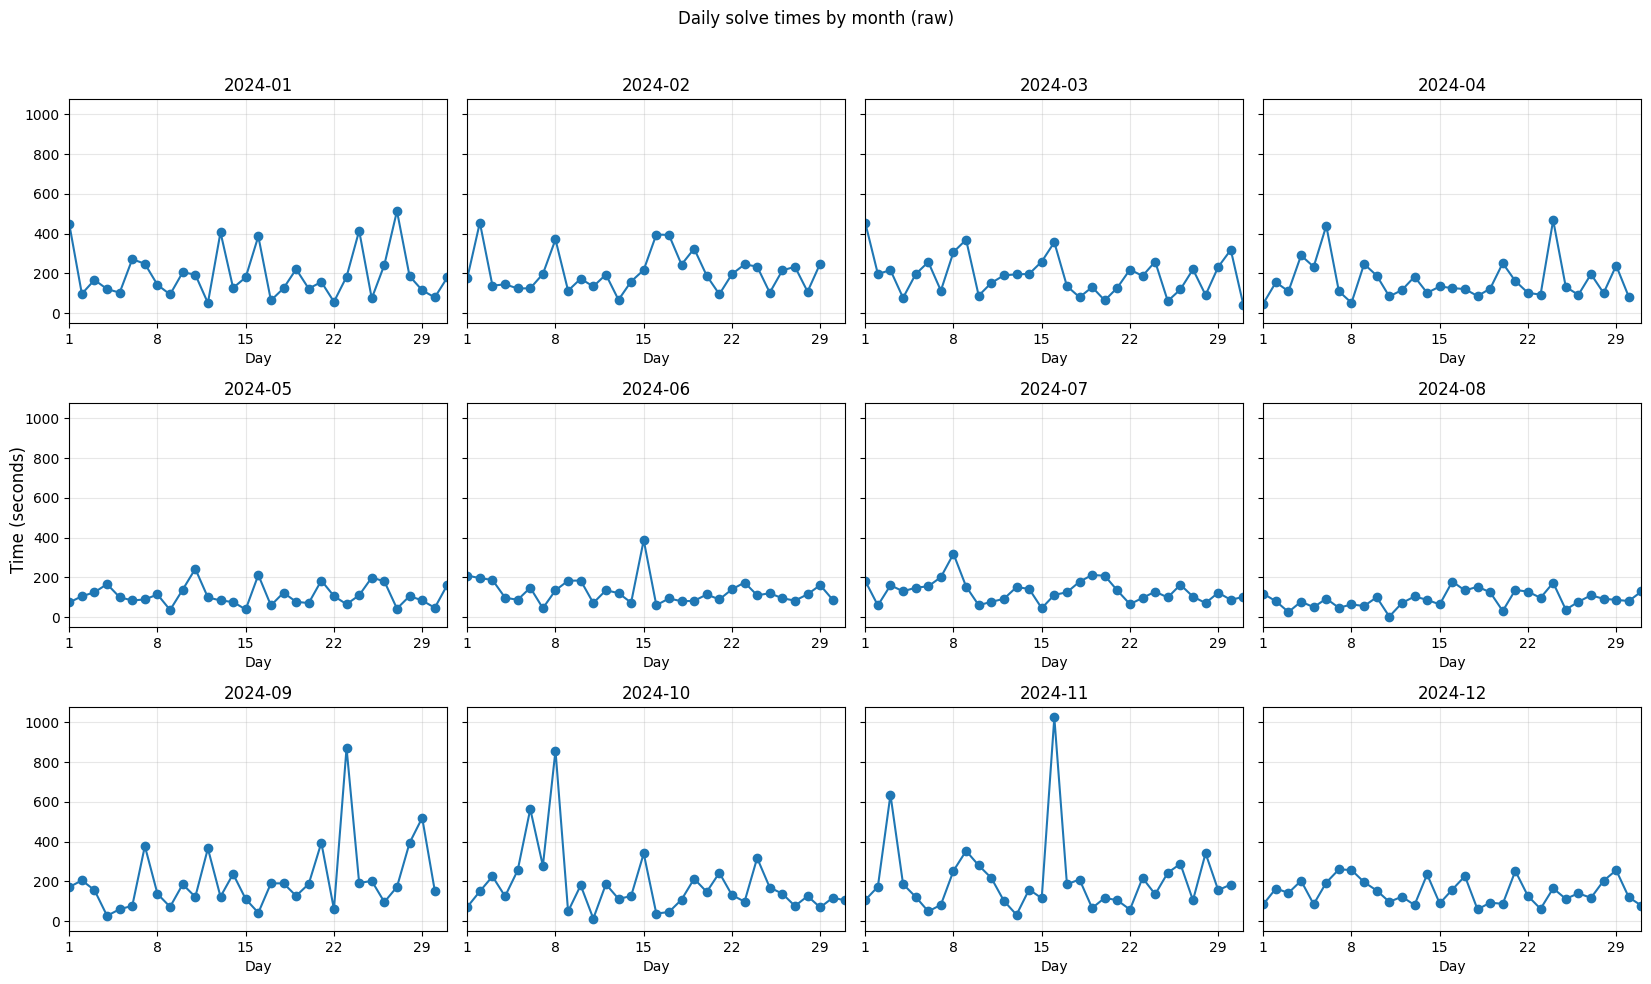

In [8]:


t_plot = t.copy()
t_plot["day"] = t_plot["date"].dt.day
months = sorted(t_plot["month"].unique())

n = len(months)
cols = 4  # rando
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4.2, rows * 3.2), sharey=True)
axes = axes.flatten()

for i, m in enumerate(months):
    ax = axes[i]
    g = t_plot[t_plot["month"] == m].sort_values("date")
    ax.plot(g["day"], g["time"], marker="o", linestyle="-")
    ax.set_title(m)
    ax.set_xlabel("Day")
    ax.grid(True, alpha=0.3)
    ax.set_xlim(1, 31)
    ax.set_xticks([1, 8, 15, 22, 29])  # fewer ticks so it stays readable

# hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.supylabel("Time (seconds)")
fig.suptitle("Daily solve times by month (raw)", y=1.02)
plt.tight_layout()
plt.show()

### This year i recall being adamant about doing the mini everyday and not forgetting hence the consistency in lower times


